In [55]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid
import math
from sklearn.metrics import accuracy_score, f1_score
import autograd.numpy as np
from autograd import grad
import torch
%matplotlib inline

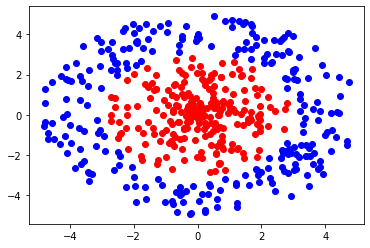

In [56]:
np.random.seed(0)
def make_dataset(num_points):
    radius = 5
    data = []
    labels = []
    # Generate positive examples (labeled l).
    for i in range(num_points//2):
        r = np.random.uniform(0, radius*0.58)
        angle = np.random.uniform(0, 2*math.pi)
        x = r * math.sin(angle)
        y = r * math.cos(angle)
        data.append([x, y])
        labels.append(1)
    #GEenrate negative examples (labeled 0).
    for i in range(num_points//2):
        r = np.random.uniform(radius*0.62, radius)
        angle = np.random.uniform(0, 2*math.pi)
        x = r * math.sin(angle)
        y = r * math.cos(angle)
        data.append([x, y])
        labels.append(0)
        
    data = np.asarray(data)
    labels = np.asarray(labels)
    return data, labels

num_data = 500
data, labels = make_dataset(num_data)

# Note: red indicates a label of 1, blue indicates a lebel of 0
plt.scatter(data[:num_data//2, 0], data[:num_data//2, 1], color='red')
plt.scatter(data[num_data//2:, 0], data[num_data//2:, 1], color='blue')


# Parameters

In [57]:
# First, initialize our neural network parameters. Params will be passed as an argument of backprop code
params = {}
input_size = 2
hidden_size = 10
output_size = 1
np.random.seed(100)
W1 = np.random.randn(hidden_size, input_size) * 0.01
b1 = np.zeros((hidden_size, 1))
W2 = np.random.randn(output_size, hidden_size) * 0.01
b2 = np.zeros((output_size, 1))
params = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

# Manual Backpropagation

In [58]:
#implement backpropagation by vector-Jacobinan product of each step.  
def backprop_manual(X, y, params):
    N = X.shape[0]
    z1 = np.dot(W1, X.T) + b1
    a1 = np.tanh(z1)
    z2 = np.dot(W2, a1) + b2
    y_hat = 1 / (1 + np.exp(-z2))
#Calculating loss 
    loss = (1. /N) * np.sum(-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat))
#Calculating derivates of the two layers and their functions
    dL_dy_hat = y_hat - y.T
    dz2 = dL_dy_hat * y_hat * (1 - y_hat)    
    dW2 = (1. / N) * np.dot(dz2, a1.T)
    db2 = (1. / N) * np.sum(dz2, axis=1, keepdims=True)
    da1 = np.dot(W2.T, dz2)
    dz1 = da1 * (1 - np.tanh(z1)**2)
    dW1 = (1. / N) * np.dot(dz1, X)
    db1 = (1. / N) * np.sum(dz1, axis=1, keepdims=True)
#Dictionary with four keys  'W1', 'W2', 'b1', and 'b2'
    grads = {
        'W1' :dW1, 'W2':dW2, 'b1':db1, 'b2':db2
    }
    return grads, loss

Note: Using 3000 Steps yeilds us a loss of 0.03 but here we have used steps =1000

In [59]:
num_steps = 1000
alpha = 1
losses = []
for step in range(num_steps):        
    grads, loss = backprop_manual(data, labels, params)
    for k in params:
        params[k] -= alpha * grads[k]
    losses.append(loss)
    if step % 50 == 0:
        print("Step {:3d} | Loss {:3.2f}".format(step, loss))

Step   0 | Loss 0.69
Step  50 | Loss 0.69
Step 100 | Loss 0.69
Step 150 | Loss 0.69
Step 200 | Loss 0.69
Step 250 | Loss 0.69
Step 300 | Loss 0.69
Step 350 | Loss 0.69
Step 400 | Loss 0.69
Step 450 | Loss 0.68
Step 500 | Loss 0.66
Step 550 | Loss 0.62
Step 600 | Loss 0.56
Step 650 | Loss 0.52
Step 700 | Loss 0.50
Step 750 | Loss 0.48
Step 800 | Loss 0.48
Step 850 | Loss 0.47
Step 900 | Loss 0.46
Step 950 | Loss 0.40


In [60]:
def predict(X, params):
    Z1 = np.dot(params['W1'], X.T) + params['b1']
    A1 = np.tanh(Z1)
    Z2 = np.dot(params['W2'], A1) + params['b2']
    y_pred = sigmoid(Z2)
    return y_pred.reshape(-1)

# Making predictions on the dataset
y_pred = predict(data, params)

# Convert into binary values
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculating accuracy and F1 score
accuracy = accuracy_score(labels, y_pred_binary)
f1 = f1_score(labels, y_pred_binary)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))

Accuracy: 90.40%
F1 Score: 90.51%


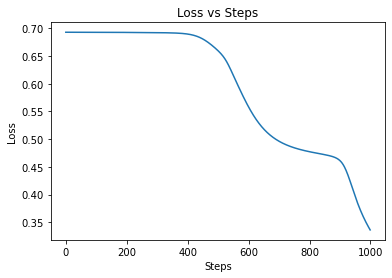

In [41]:
plt.plot(range(num_steps), losses)
plt.xlabel('Steps')
plt.ylabel('Loss')
#plotting loss vs training steps for implementation using vector-Jacobinan product
plt.title('Loss vs Steps')
plt.show()

Running Parameters again

In [42]:
params = {}
input_size = 2
hidden_size = 10
output_size = 1
np.random.seed(0)
W1 = np.random.randn(hidden_size, input_size) * 0.01
b1 = np.zeros((hidden_size, 1))
W2 = np.random.randn(output_size, hidden_size) * 0.01
b2 = np.zeros((output_size, 1))
params = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

# Backpropagation using Autograd

In [43]:
def sigmoid(x):
    return 1. / (1 + np.exp(-x))
def forward(X, params):
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']
    z1 = np.dot(W1, X.T) + b1
    a1 = np.tanh(z1)
    z2 = np.dot(W2, a1) + b2
    y_hat = sigmoid(z2)
    return y_hat
def loss_function(params, X, y):
    y_hat = forward(X, params)
    N = X.shape[0]
    loss = (1./N) * np.sum(-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat))
    return loss
def backprop_autograd(X, y, params):
    N = X.shape[0]
    loss = loss_function(params, X, y)
    gradients = grad(loss_function)(params, X, y)
    grads = {'W1': gradients['W1'], 'b1': gradients['b1'], 'W2': gradients['W2'], 'b2': gradients['b2']}
    return grads, loss

In [44]:
num_steps = 1000
alpha = 1
losses = []
for step in range(num_steps):        
    grads, loss = backprop_autograd(data, labels, params)
    for k in params:
        params[k] -= alpha * grads[k]
    losses.append(loss)
    if step % 50 == 0:
        print("Step {:3d} | Loss {:3.2f}".format(step, loss))

Step   0 | Loss 0.69
Step  50 | Loss 0.69
Step 100 | Loss 0.69
Step 150 | Loss 0.53
Step 200 | Loss 0.46
Step 250 | Loss 0.22
Step 300 | Loss 0.15
Step 350 | Loss 0.12
Step 400 | Loss 0.10
Step 450 | Loss 0.09
Step 500 | Loss 0.08
Step 550 | Loss 0.07
Step 600 | Loss 0.06
Step 650 | Loss 0.06
Step 700 | Loss 0.05
Step 750 | Loss 0.05
Step 800 | Loss 0.05
Step 850 | Loss 0.05
Step 900 | Loss 0.04
Step 950 | Loss 0.04


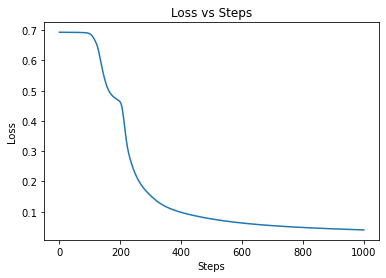

In [46]:
plt.plot(range(num_steps), losses)
plt.xlabel('Steps')
plt.ylabel('Loss')
#Plotting loss vs Training for implementation using autograd 
plt.title('Loss vs Steps')
plt.show()

In [53]:
y_pred = (predict(data, params) > 0.5).astype(int)
accuracy = np.mean(y_pred == labels)
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))

Accuracy: 99.60%
F1 Score: 90.51%


Running Parameters again

In [47]:
params = {}
input_size = 2
hidden_size = 10
output_size = 1
np.random.seed(0)
W1 = np.random.randn(hidden_size, input_size) * 0.01
b1 = np.zeros((hidden_size, 1))
W2 = np.random.randn(output_size, hidden_size) * 0.01
b2 = np.zeros((output_size, 1))
params = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

# Backpropagation using Pytorch

In [48]:
def backprop_pytorch(X, y, params):
    X = torch.from_numpy(X)
    y = torch.from_numpy(y)
    #Paramaters 
    W1 = torch.tensor(params['W1'], requires_grad=True)
    b1 = torch.tensor(params['b1'], requires_grad=True)
    W2 = torch.tensor(params['W2'], requires_grad=True)
    b2 = torch.tensor(params['b2'], requires_grad=True)
    z1 = torch.matmul(W1, X.T) + b1
    a1 = torch.tanh(z1)
    z2 = torch.matmul(W2, a1) + b2
    y_hat = torch.sigmoid(z2)
    loss_fn = torch.nn.BCELoss()
    loss = loss_fn(y_hat[0].float(), y.float())
    loss.backward()
    #Gradiants in dictionary 
    grads = {'W1': W1.grad.numpy(), 'b1': b1.grad.numpy(),
             'W2': W2.grad.numpy(), 'b2': b2.grad.numpy()}
    return grads, loss.item()

In [49]:
num_steps = 1000
alpha = 1
losses = []
for step in range(num_steps):        
    grads, loss = backprop_pytorch(data, labels, params)
    for k in params:
        params[k] -= alpha * grads[k]
    losses.append(loss)
    if step % 50 == 0:
        print("Step {:3d} | Loss {:3.2f}".format(step, loss))

Step   0 | Loss 0.69
Step  50 | Loss 0.69
Step 100 | Loss 0.69
Step 150 | Loss 0.53
Step 200 | Loss 0.46
Step 250 | Loss 0.22
Step 300 | Loss 0.15
Step 350 | Loss 0.12
Step 400 | Loss 0.10
Step 450 | Loss 0.09
Step 500 | Loss 0.08
Step 550 | Loss 0.07
Step 600 | Loss 0.06
Step 650 | Loss 0.06
Step 700 | Loss 0.05
Step 750 | Loss 0.05
Step 800 | Loss 0.05
Step 850 | Loss 0.05
Step 900 | Loss 0.04
Step 950 | Loss 0.04


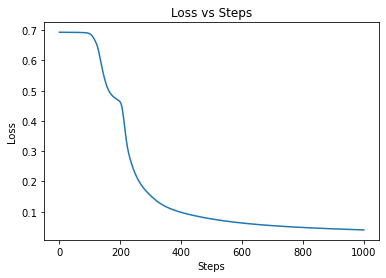

In [52]:
plt.plot(range(num_steps), losses)
#PLotting Loss vs Steps for impementation using pytorch
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Loss vs Steps')
plt.show()

In [54]:
y_pred = (predict(data, params) > 0.5).astype(int)
accuracy = np.mean(y_pred == labels)
#Calculating Accuracy and F1 score
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("F1 Score: {:.2f}%".format(f1 * 100))

Accuracy: 99.60%
F1 Score: 90.51%
